In [1]:
"""
The attached file contains a Salinas hyperspectral image.

Reduce its dimensions using PCA.
Perform clustering using k-means for different dimensions and compare the results with the clusters in the salinas_gt file.
"""

'\nThe attached file contains a Salinas hyperspectral image.\n\nReduce its dimensions using PCA.\nPerform clustering using k-means for different dimensions and compare the results with the clusters in the salinas_gt file.\n'

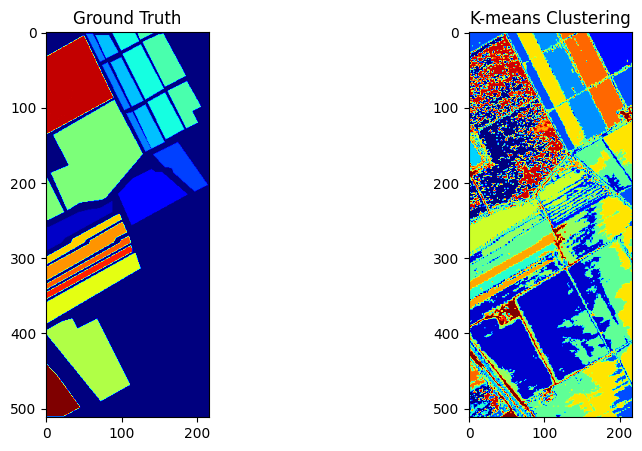

Clustering accuracy: 0.03


In [36]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = 216  # Number of principal components
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_reshaped)

# Perform k-means clustering
n_clusters = len(np.unique(ground_truth)) - 1  # Number of clusters (excluding background)
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(data_pca)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat > 0  # Exclude background
accuracy = accuracy_score(ground_truth_flat[mask], clusters_flat[mask])
print(f'Clustering accuracy: {accuracy:.2f}')

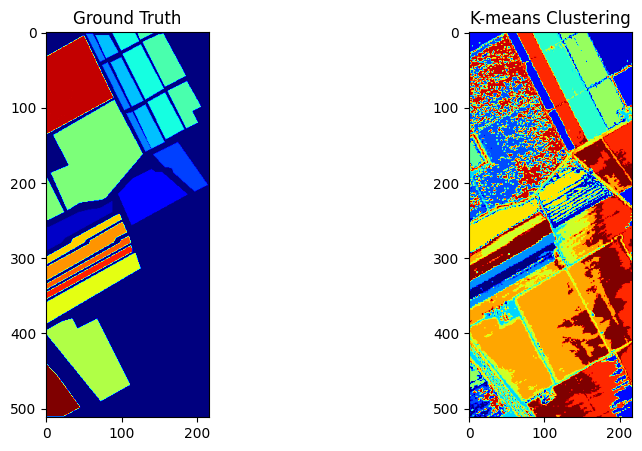

Clustering accuracy (Hungarian-aligned): 0.67
ARI: 0.52, NMI: 0.72


In [39]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = 216  # Choose number of principal components
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_reshaped)

# Perform k-means clustering
n_clusters = len(np.unique(ground_truth)) - 1  # Exclude background
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
clusters = kmeans.fit_predict(data_pca)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat > 0  # Exclude background

# Adjust cluster labels using Hungarian algorithm
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(ground_truth_flat[mask], clusters_flat[mask])
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
accuracy = conf_matrix[row_ind, col_ind].sum() / mask.sum()

# Evaluate clustering with ARI and NMI
ari = adjusted_rand_score(ground_truth_flat[mask], clusters_flat[mask])
nmi = normalized_mutual_info_score(ground_truth_flat[mask], clusters_flat[mask])

print(f'Clustering accuracy (Hungarian-aligned): {accuracy:.2f}')
print(f'ARI: {ari:.2f}, NMI: {nmi:.2f}')


In [31]:
print(n_clusters)

16


In [32]:
print(np.max(ground_truth))

16


In [25]:
print(clusters)

[4 4 4 ... 4 4 4]


In [30]:
print(ground_truth)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [16 16 16 ...  0  0  0]
 [16 16 16 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [26]:
print(ground_truth_flat)

[0 0 0 ... 0 0 0]


In [16]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']

print(data)


[[[290 381 585 ...  11  17  10]
  [290 381 519 ...  11  15  16]
  [290 381 585 ...  11  11  12]
  ...
  [373 482 594 ...   4   0   4]
  [373 482 659 ...   0   5   0]
  [305 393 655 ...   1  -3  -2]]

 [[379 400 600 ...  11  15   8]
  [308 400 535 ...  15  13   8]
  [379 483 535 ...   5  15   8]
  ...
  [376 477 590 ...   0  -5   1]
  [376 477 590 ...   0  13   1]
  [305 393 655 ...   1  -3  -2]]

 [[369 495 604 ...   9  17   4]
  [298 411 604 ...   5  13   6]
  [298 411 670 ...   7  13  10]
  ...
  [447 468 664 ...   7   0   1]
  [305 468 664 ...   7   2   1]
  [447 384 664 ...   1   4   3]]

 ...

 [[379 383 540 ...   5   9   4]
  [308 383 540 ...   5   5   2]
  [379 383 540 ...  -2   7   4]
  ...
  [367 387 661 ...  17  23  12]
  [367 470 661 ...  15  23  12]
  [438 470 596 ...  13  27  16]]

 [[314 479 604 ...   5   0   4]
  [314 396 539 ...   3   2  -1]
  [385 396 539 ...   1   0   6]
  ...
  [367 387 661 ...  17  23  12]
  [367 470 661 ...  15  23  12]
  [376 489 674 ...  15  23  

In [17]:
print(data.shape)

(512, 217, 224)


In [18]:
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']


In [19]:
print(ground_truth.shape)

(512, 217)
